# Sentinel 2 Cloudless Mosaic

This tutorial constructs a *cloudless mosaic* (also known as a composite) from a time series of [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) images and is modified from the example notebook provided by Microsoft. This notebook performs the following steps:

* Find a time series of images within a bounding box
* Stack those images together into a single array
* Mask clouds and cloud shadows
* Synthesize a panchromatic band by averageing Red, Green, Blue and NIR bands
* Compute the cloudless mosaic by taking a median
* Save the result to a GeoTiff

This notebook is designed for the processing of large areas, so tasks like plotting that are useful but resource-intensive are omitted

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr
import pandas as pd

import rasterio.features
import rioxarray
import stackstac
import pystac_client
import planetary_computer

import pyproj
from shapely.ops import transform
from shapely.geometry import Polygon

import xrspatial.multispectral as ms

import dask
from dask_gateway import GatewayCluster
from dask import visualize

import itertools
from datetime import datetime
from tqdm.notebook import tqdm

## Create a Dask cluster

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [2]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=32)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.169622bd58fc4fe6ab503c2cbfdb2acb/status


## Discover data

In this step we define our bounding box by creating a Shapely Polygon object. The Polygon object is created from a set of coordinate pairs in **Latitude and Longitude** (epsg 3857). A simple way of getting the coordinate pairs is by creating a bounding box in Google Earth, saving it to a kml, then opening it as a text file and copying the coordinates.

At this point, you'll have to decide if you want to process multiple years at once, or if you want to process the years separately. This decision comes down to how much compute power you have access to. For the Dask cluster parameters specified, `cluster.adapt(minimum=4, maximum=24)`, the maximum amount of images used should be less than 200. You can alter the number of images used by changing the values of `date_range`, `max_cloud`, and `pol`.

In [3]:
# date range
# year = 2016
# date_range = f"{year}-01-01/{year+1}-01-01"

date_range = "2016-01-01/2022-01-01"

# frame T60HUB or T60GUA
frames = 'T60HUB'
orbit = 'R129'
# frame = 'R129'

# max cloud coverage
max_cloud = 25

# possible bounding boxes
poroa =[[175.9540924324072,-39.79467075565404],
        [175.945114873355,-39.5925815994339],
        [175.7466289836702,-39.59528350422168],
        [175.7518945072953,-39.79792833072585],
        [175.9540924324072,-39.79467075565404]]

study_area = [[174.3195824446477,-39.31681541495579],
              [174.2992147571175,-40.1298100050477],
              [176.5561381739111,-40.14413275288879],
              [176.5430092169263,-39.32607797703585],
              [174.3195824446477,-39.31681541495579]] 

# create shapely polygon for desired area
pol = Polygon(study_area)

# get bounding box (minx, miny, maxx, maxy)
bbox = pol.bounds

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [4]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    datetime=date_range,
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"gte":0,"lte": max_cloud}},
)

# Get items with the correct relative orbit
items = list(search.get_items())

Number of images is 1299


Now we restrict the results to the same orbit

In [5]:
ids = np.array([x.id.split('_') for x in items])

#get correct orbit
ids = ids[ids[:,3] == orbit]

#get correct frames
ids = ids[np.isin(ids[:,4],frames)]

#get dates
dates = [set(ids[ids[:,4]==f,2]) for f in frames]
valid_dates = list(dates[0].intersection(*dates))
ids = ids[np.isin(ids[:,2],valid_dates)]

valid_ids = ['_'.join(x) for x in ids]

#subset items
items = [x for x in items if any([y == x.id for y in valid_ids])]

print(f'Number of images is {len(items)}')

Number of images is 100


Depending on the year, this should return about 100-150 images for our study area over space, time, and cloudiness. Those items will still have *some* clouds over portions of the scenes, though. To create our cloudless mosaic, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then reduce the time-series of images down to a single image.

In [6]:
signed_items = []
for item in items:
    item.clear_links()
    signed_items.append(planetary_computer.sign(item).to_dict())

## Load Data

In this step we load the data and perform some initial cleaing that includes:
* subsetting to our exact bounding box
* removing pixels that correspond clouds and clouds shadows

To perform our cloud masking, we use Sentinel-2's Scene Classification Layer ([SCL](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm)) and mask out values 3, 8, 9, and 10.

In [7]:
data = (
    stackstac.stack(
        signed_items,
        assets=["B08","SCL"],
        chunksize=4096,
        resolution=10,
        epsg=32760
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
)

# Get bounding box in projection of data
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS(data.crs), always_xy=True).transform
pol_utm = transform(project, pol)
minx, miny, maxx, maxy = pol_utm.bounds

# Subset data and mask clouds
data = data.sel(x=slice(minx, maxx), y=slice(maxy,miny))

# Merge neighboring images
# data = data.groupby('time').mean()

## Cloud filtering

In [8]:
first = data.groupby('time').first(skipna=False)
valid = xr.where(first.sel(band='SCL',drop=True).isin([3,8,9]),x=0,y=1)

In [9]:
pct_valid = valid.sum(dim=['x','y']).compute().to_numpy() / (data.shape[2] * data.shape[3])
pct_valid = pct_valid.squeeze()
dates = valid.time.to_numpy()

In [10]:
clouds = pd.DataFrame({'date':dates,'pct_valid':pct_valid[:]})
clouds.to_csv('clouds.csv',index=False)

In [15]:
clouds = pd.read_csv('clouds.csv',parse_dates=['date'])

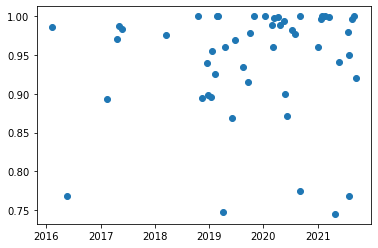

In [16]:
plt.scatter(clouds.date,clouds.pct_valid)

(26, 2)


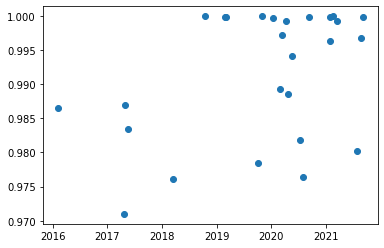

In [17]:
best = clouds.loc[clouds.pct_valid > 0.97].copy()
print(best.shape)
plt.scatter(best.date,best.pct_valid)

## Summarizing

In [24]:
merge_dates = data.sel(band=["B08"]).squeeze().groupby('time').mean().sel(time=list(best.date)).squeeze()

In [ ]:
median = merge_dates.groupby('time.year').median().fillna(0).persist()

## Download Data

In [28]:
median = median.rio.write_crs(pyproj.CRS(data.crs).to_string())
median = median.rename('Panchromatic')

In [30]:
%%time
for y in median.year.to_numpy():
    name = f's2_l2_{y}0601.tif'
    print(name)
    median.sel(year=y).rio.to_raster(name)

s2_l2_20160601.tif
s2_l2_20170601.tif
s2_l2_20180601.tif
s2_l2_20190601.tif
s2_l2_20200601.tif
s2_l2_20210601.tif
CPU times: user 9.59 s, sys: 11.6 s, total: 21.2 s
Wall time: 26.3 s


## Close cluster
Once we're done with our processing, let's be a good steward of our resources and close our cluster

In [31]:
cluster.close()

## Download Data
And you're done! The completed GeoTiff files should be in the same directory as this notebook, and can be downloaded via Jupyter's GUI